<a href="https://jupyterhub.user.eopf.eodc.eu/hub/user-redirect/git-pull?repo=https://github.com/atsiokanos/eopf-101&branch=6_a_general_overview_of_the_topic_gww&urlpath=lab/tree/eopf-101/65_gww.ipynb" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

Water reservoirs are essential for water supply, energy production, and irrigation. However, population growth, economic expansion, and climate change are increasing pressure on these resources, affecting water availability and raising the risk of droughts and floods. Reliable monitoring of reservoirs is critical to ensure sustainable water management and water security. This is especially important in transboundary basins, where upstream reservoirs can significantly influence water availability for downstream countries.

The [Global Water Watch (GWW)](https://www.globalwaterwatch.earth/) is a platform developed by [Deltares](https://www.deltares.nl/en) and supported by [Google.org](https://www.google.org/), the [Water, Peace, and Security Partnership](https://waterpeacesecurity.org/), and the [European Space Agency (ESA)](https://www.esa.int/). It provides near-real-time (NRT), globally accessible information on reservoirs using Earth Observation data, helping stakeholders monitor changes in water extent and manage resources more effectively. A detailed description of GWW methods is available under *High-resolution surface water dynamics in Earth’s small and medium-sized reservoirs* by Donchyts et al., [here](https://www.nature.com/articles/s41598-022-17074-6).  

In this notebook, we **implement parts of the GWW algorithms** to estimate water extent for a single reservoir: **Mita Hills in Zambia**. Although the original GWW algorithm uses **Landsat 7 & 8** as well as **Sentinel-2**, we focus only on **Sentinel-2 (L1C) imagery** here for simplicity. For the purpose of this resource, we use Sentinel-2 (L1C) imagery available through the [EOPF STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en).

Section 1 focuses on preparing and preprocessing the Sentinel-2 data, while Section 2 covers the steps required to estimate reservoir water extent using the GWW methodology.


### What we will learn


- Retrieve Sentinel-2 L1C data from the EOPF STAC Catalog

- Preprocess Sentinel-2 L1C imagery and filter out low-quality scenes

- Compute the Normalized Difference Water Index (NDWI) to highlight water bodies

- Apply the GWW algorithm to Sentinel-2 L1C data to generate water masks and fill missing water pixels (e.g., due to clouds or shadows)

- Extract the largest connected component and estimate the water surface area

- Efficiently process large image collections using parallel computing techniques with Dask



<hr>

#### Import libraries

In [1]:
# Parallel computing and large data handling
import dask                                  
from dask.distributed import Client          
import pandas as pd

# Data access
from pystac_client import Client as StacClient   # Query EO datasets via STAC API
from pystac import MediaType                     # Identify asset media types (e.g., ZARR)

# Geospatial data processing
from pyproj import CRS, Transformer            
import xarray as xr                        
import rioxarray
from rasterio.enums import Resampling           # Resampling method for reprojection

# Visualization
import matplotlib.pyplot as plt                


#### Helper functions

This notebook utilizes a set of helper functions from the Python file [reservoir_surface_monitoring_utils.py](./reservoir_surface_monitoring_utils.py)  to handle key tasks, including loading and preprocessing the datasets, computing water masks using the GWW algorithm, and calculating reservoir areas. The main logic of each function is outlined in the notebook prior to its use, and the full code can be inspected in `reservoir_surface_monitoring_utils.py`.


In [ ]:
from reservoir_surface_monitoring_utils import (
    list_found_elements,
    load_datatrees,
    preprocess_datatree,
    gww,
    largest_connected_component,
    compute_area_km2,
)

<hr>

## Section 1 - Data Preparation


**Overview of Section 1**:

**1.1 - Initial settings and data connection**    
**1.2 - Load and preprocess data**  
**1.3 - Filtering data**    

### 1.1 - Initial settings and data connection

Initiate dask client for parallel processing

In [ ]:
# Start dask client 
client = Client()  # local cluster, can monitor dashboard
print(client)
print(client.dashboard_link)

<Client: 'tcp://127.0.0.1:55949' processes=4 threads=12, memory=15.64 GiB>
http://127.0.0.1:8787/status


2025-11-24 13:03:48,528 - distributed.scheduler - WARNING - Worker failed to heartbeat for 2139s; attempting restart: <WorkerState 'tcp://127.0.0.1:55968', name: 0, status: running, memory: 0, processing: 0>
2025-11-24 13:03:48,620 - distributed.scheduler - WARNING - Worker failed to heartbeat for 2139s; attempting restart: <WorkerState 'tcp://127.0.0.1:55969', name: 1, status: running, memory: 0, processing: 0>
2025-11-24 13:03:48,625 - distributed.scheduler - WARNING - Worker failed to heartbeat for 2139s; attempting restart: <WorkerState 'tcp://127.0.0.1:55970', name: 2, status: running, memory: 0, processing: 0>
2025-11-24 13:03:48,629 - distributed.scheduler - WARNING - Worker failed to heartbeat for 2139s; attempting restart: <WorkerState 'tcp://127.0.0.1:55971', name: 3, status: running, memory: 0, processing: 0>
2025-11-24 13:03:52,296 - distributed.nanny - WARNING - Restarting worker
2025-11-24 13:03:52,335 - distributed.nanny - WARNING - Restarting worker
2025-11-24 13:03:52,

Define the settings and retrieve Sentinel-2 L1C data from the EOPF STAC Catalog. In this example, we will use the bounding box covering Mita Hills, apply a 30% cloud cover cutoff for the query, and select a two-year period from 2023 to 2024. This relatively long period ensures a sufficient number of scenes, covering both dry and wet conditions.

In [4]:
# Define AOI bbox coordinates (minx, miny, maxx, maxy) in EPSG:4326 (WGS 84)
minx, miny, maxx, maxy = 28.99253107, -14.2426452, 29.17046702, -13.95317373

# Define time range
start_date = "2023-01-01" 
end_date = "2024-12-01"

# Define cloud cover cutoff percentile
cloud_cutoff_percentile = 30  # e.g., 30%

# Define collection
collection = "sentinel-2-l1c"

# Connect to EOPF STAC Catalog
eopf_stac_api_root_endpoint = "https://stac.core.eopf.eodc.eu/"
eopf_catalog = StacClient.open(url=eopf_stac_api_root_endpoint)

# Start a search
s2_collection = eopf_catalog.search(
    collections=collection,
    bbox=(minx, miny, maxx, maxy),
    datetime=f"{start_date}T00:00:00Z/{end_date}T23:59:59Z",
    query = {'eo:cloud_cover': {'lte': cloud_cutoff_percentile}}
)

# List found scenes
scenes = list_found_elements(s2_collection)
print(f"Total items found for collection {collection} over AOI:", len(scenes[0]))

# Retrieve ZARR URLs/paths
S2l1c_coll = eopf_catalog.get_collection(collection)
items_loc_url = []

for item_id in scenes[0]:
    item = S2l1c_coll.get_item(id=item_id)
    item_assets = item.get_assets(media_type=MediaType.ZARR)
    cloud_storage_url = item_assets['product'].href
    items_loc_url.append(cloud_storage_url)

Total items found for collection sentinel-2-l1c over AOI: 96


### 1.2 - Load and preprocess data

First we load the datasets using the `load_datatrees` function. Note that in the following cell loading is done lazily using `dask.delayed`, which builds a Dask task graph. Execution of this graph triggers **parallel processing** of all dataset loading tasks, improving efficiency and reducing memory usage.


In [5]:
# Load datatrees in parallel using dask.delayed
delayed_datatrees = [dask.delayed(load_datatrees)(path) for path in items_loc_url]
datatrees = dask.compute(*delayed_datatrees)

The obtained datatrees contain the full set of source bands (at all available resolutions) as well as useful metadata for every retrieved scene. Some preprocessing is necessary. This is handled by the `preprocess_datatree` function, which extracts only the bands of interest, i.e. green (b03) and NIR (b08), clips the tile to the AOI, merges the two bands into a single dataset, and finally adds a **time dimension** derived from the datatree attributes ("stac_discovery" / "properties" / "start_datetime").

Although the search coordinates are given in geographic coordinates (EPSG:4326), the data retrieved from the **EOPF STAC API** is provided in UTM coordinates. Therefore, we need to convert the AOI coordinates to UTM as well, to ensure that the clipping is performed correctly. The image CRS code is also available in the datatree attributes.

In [6]:
# get the scenes crs from the attributes of the first datatree
crs_code = datatrees[0].attrs["other_metadata"]["horizontal_CRS_code"]  
print("Scene CRS code:", crs_code)

# Build CRS object and transformer from WGS84
scene_crs = CRS.from_user_input(crs_code)
project_to_scene = Transformer.from_crs("EPSG:4326", scene_crs, always_xy=True)

# Transform bounding box to scene CRS 
minx_utm, miny_utm = project_to_scene.transform(minx, miny)
maxx_utm, maxy_utm = project_to_scene.transform(maxx, maxy)

Scene CRS code: EPSG:32735


Apply the preprocessing and compute the datasets

In [7]:
# Preprocess datatrees in parallel using dask.delayed
delayed_datasets = [
    dask.delayed(preprocess_datatree)(
        dtree,
        minx_utm,
        miny_utm,
        maxx_utm,
        maxy_utm,
    )
    for dtree in datatrees
]

datasets = dask.compute(*delayed_datasets)

c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 60.19 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Create a datacube with all datasets along time dimension

In [8]:
# Combine all datasets along time dimension
data_cube = xr.concat(datasets, dim="time")
# Sort by time
data_cube = data_cube.sortby("time")

### 1.3 - Filtering data

Although we selected scenes with less than 30% cloud coverage in our query, this threshold applies to the entire tile, meaning some clouds may still be present in the clipped `data_cube`. 

To address this, we first assign a quality score to each image using the green band by computing the 75th percentile (default in GWW) over the AOI (clouds have high reflectance so the lower the score the cleaner). 

We then keep only the cleanest scenes based on a chosen percentage of the total images (in our case 75%).

Notes to consider: 

1) This step requires a long time series with a relatively large number of images (for example, in this notebook we use two years with around 100 images). If you are focusing on a shorter period, you can skip this subsection and move directly to Section 2.

2) Selecting scenes with less than 30% cloud coverage can be somewhat arbitrary. A more accurate estimate could be obtained from climatology data, for example using the MODIS cloud occurrence dataset.

3) Keeping the top 75% of the cleanest images is also somewhat arbitrary.

4) All of the above filtering settings may reduce the number of final cleaned images compared to the number used/provided by the official GWW algorithm over the same period, although only minor differences are expected.

In [9]:
# Compute quality scores based on green band 75th percentile
quality_scores = data_cube["green"].quantile(
    q=0.75,
    dim=("y", "x"),
    skipna=True
)
# Store quality scores in data cube
data_cube["quality_score"] = quality_scores

In [10]:
# Keep the 75% cleanest scenes based on quality scores
keep_fraction = 0.75

# Only compute the quality_score array
qs = data_cube["quality_score"].compute().values 
n_keep = max(int(len(qs) * keep_fraction), 1)

# Indices of the n_keep smallest values
sorted_idx = qs.argsort()[:n_keep]

# Select those scenes from dataset 
data_cube = data_cube.isel(time=sorted_idx).sortby("time")

Finally, we have a clipped and cleaned `data_cube` containing all scenes, including a **time dimension** for the relevant bands as data variables (`time`, `lat`, `lon`). We will use this dataset in **Section 2** to perform time series analysis, namely to derive water extents and calculate the area for each scene.

<hr>

## Section 2 - Reservoir Water Surface Estimation

**Overview of Section 2:**

**2.1 - Compute Normalized Difference Water Index (NDWI)**    
**2.2 - Integrate Water Occurrence (WO) data**  
**2.3 - Generate water extents (core GWW algorithm)**  
**2.4 - Extract Largest Connected Component**  
**2.5 - Compute reservoir area**  



### 2.1 - Compute Normalized Difference Water Index (NDWI)

Once we have preprocessed and prepared the data for our AOI, we can start by computing the Normalized Difference Water Index (NDWI) using the green (b03) and NIR (b08) bands. The NDWI highlights water features by producing high positive values for water pixels and lower or negative values for land and vegetation. This provides an initial indication of where water is located, although simple thresholding at this stage can be unreliable, particularly near shorelines or in areas with shallow water or vegetation.

In [11]:
# calculate NDWI
green = data_cube['green']
nir = data_cube['nir']
ndwi = (green - nir) / (green + nir)

Visualize example output from Subsection 2.1

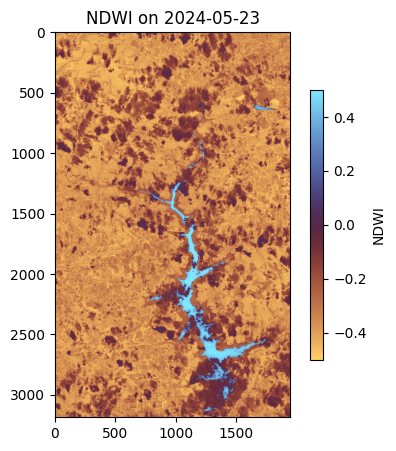

In [12]:
# Plot NDWI for a specific date as an example
plt.figure(figsize=(5, 5))
plt.imshow(ndwi.sel(time='2024-05-23'), vmin=-0.5, vmax=0.5, cmap='managua')
plt.colorbar(label='NDWI', shrink=0.7)
plt.title('NDWI on 2024-05-23');

As shown in the plot, the water body area is visible, with high values represented by the deep sky-blue color. However, clouds are present within the water body area.


### 2.2 - Integrate Water Occurrence (WO) data

The Global Surface Water Explorer (GSWE) dataset from the European Commission's Joint Research Centre is also used here. This dataset maps the location and temporal distribution of water surfaces at the global scale over the past 32 years, providing statistics on the extent and change of those water surfaces, namely water occurence (WO) probabilities per pixel. WO represents the fraction of time a given pixel was observed as water over the study period. The table below shows the range of values and their interpretation.


### Interpretation of Pixel Values in GSWE (Water Occurrence Layer)

| **Pixel Value (range)** | **Interpretation** | **Typical Environment** |
|--------------------------|--------------------|--------------------------|
| 0.0                     | Never detected as water during the observation period | Land, desert, urban area |
| 0.1 – 0.5               | Occasionally detected as water (intermittent presence) | Seasonal ponds, floodplains, agricultural fields |
| 0.5 – 0.9               | Frequently water but not permanent | Wetlands, seasonal lakes, riverbanks |
| ~1.0                    | Almost always water (permanent presence) | Lakes, large rivers, reservoirs |

For more infomration the user is referred to the [associated journal article](https://www.nature.com/articles/nature20584) and the online [Data Users Guide](https://storage.googleapis.com/global-surface-water/downloads_ancillary/DataUsersGuidev2021.pdf)

The WO dataset is static. For this exercise, we have stored a subset over our AOI (under the `data` folder), which we will read. In general, the dataset can be downloaded [here](https://global-surface-water.appspot.com/download) or accessed through **Google Earth Engine**. At the end of this notebook, in the example tasks, a code snippet is provided showing how the WO dataset can be downloaded and processed using `ee` and/or `geemap`.

The **GSWE** will be used in the next step to perform some filling over the initally classified water areas.


In [13]:
ds_wo = rioxarray.open_rasterio("data/water_occurrence_utm35_v14.tif")
ndwi.rio.write_crs(crs_code, inplace=True)

# resample it to match ndwi as it is on a 30m resolution
ds_wo_matched = ds_wo.rio.reproject_match(
    ndwi,
    resampling=Resampling.nearest
)
ds_wo_matched = ds_wo_matched[0]

Visualize example output from Subsection 2.2

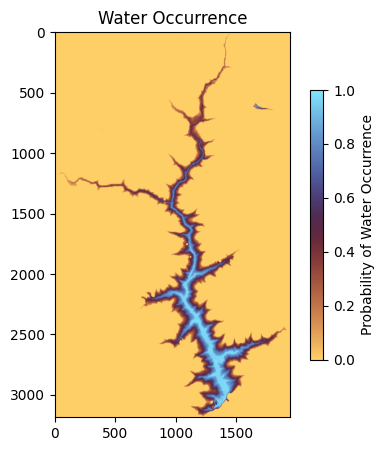

In [14]:
# Plot WO
plt.figure(figsize=(5, 5))
plt.imshow(ds_wo_matched, vmin=0, vmax=1, cmap='managua')
plt.colorbar(label='Probability of Water Occurrence', shrink=0.7)
plt.title('Water Occurrence');

As shown in the plot, the main water body has very high probability values, close to one, indicating that these pixels were almost always water during the observation period, representing the permanent water areas of the reservoir. Lower values appear near the edges of the reservoir, which are the most challenging areas to detect. These lower probabilities typically indicate that water was present frequently but not permanently (values around 0.5–0.9) or only occasionally (values around 0.1–0.5). In the next subsection, we will focus on detecting these variable water areas in each image.


### 2.3 - Generate water extents (core GWW algorithm)

To detect water more reliably, we combine the following two datasets: the NDWI index and the Water Occurrence (WO).

First, we identify edges in the NDWI image using the `Canny`, which highlights sharp transitions between water and land. After that, we apply a morphological dilation to the edges, and using only these dilated edge pixels, we apply Otsu thresholding to determine a robust cutoff value that separates water from land. This avoids biases from large uniform land areas and ensures the threshold is focused on transition zones. For more details on the Canny edge detector and Otsu thresholding see this [publication](http://www.mdpi.com/2072-4292/8/5/386).

Next, we use the WO dataset to fill in water areas that NDWI might miss, such as shallow, turbid zones etc. The 80th percentile of the WO values is computed only on the edge pixels, making the filling threshold context-aware. This filling also helps recover water in pixels obscured by clouds or shadows in the current image. Water is added in areas that are classified as non-water (NDWI<0 here, -0.15 in raw GWW) but exceed the WO threshold.

Finally, the water mask from NDWI and the filled water mask from WO are combined to produce the total water mask.

*The code for the steps described above can be found in the `gww` function.*

In [15]:
water_mask_da, water_fill_da, total_water_da = xr.apply_ufunc(
    gww,
    ndwi,              # NDWI array
    ds_wo_matched,     # Water occurrence array
    input_core_dims=[["y", "x"], ["y", "x"]],
    output_core_dims=[["y", "x"], ["y", "x"], ["y", "x"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[bool, bool, bool],
    dask_gufunc_kwargs={"allow_rechunk": True},
    kwargs={
        "canny_sigma": 0.7,        # Sigma for Canny edge detector
        "canny_low": 0.5,          # Canny low threshold
        "canny_high": 1.0,         # Canny high threshold
        "nonwater_thresh": 0       # NDWI non-water threshold, used to fill water pixels from WO
    }
)


Visualize example output from Subsection 2.3

c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 24.66 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


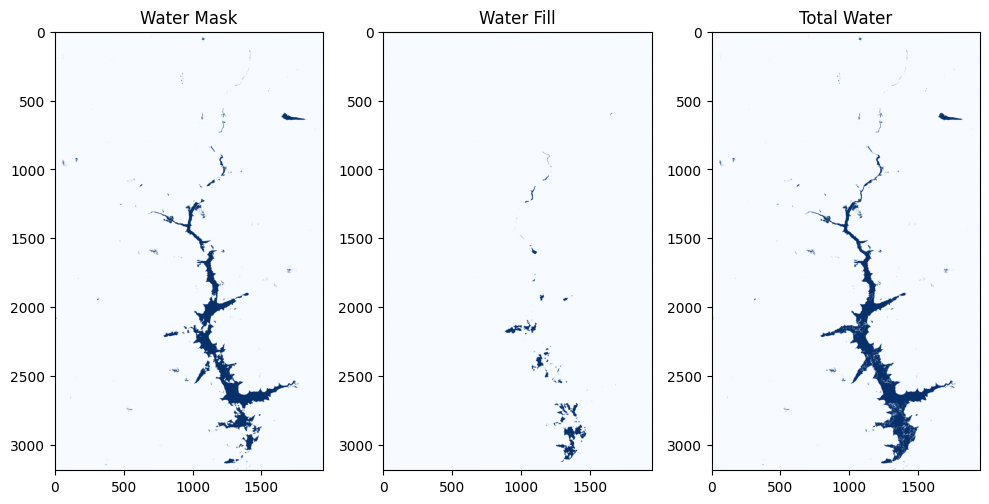

In [16]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(water_mask_da.sel(time="2024-05-23").compute(), cmap='Blues')
plt.title('Water Mask')
# plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(water_fill_da.sel(time="2024-05-23").compute(), cmap='Blues')
plt.title('Water Fill')
# plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(total_water_da.sel(time="2024-05-23").compute(), cmap='Blues')
plt.title('Total Water')
# plt.axis('off')

plt.tight_layout()
plt.show()

In the example scene from 2024-05-23 shown in the figure above, the left panel displays the initial water detected using Otsu, the middle panel shows the water filling based on the WO dataset, and the right panel presents the total detected water produced by our algorithm.

### 2.4 - Extract Largest Connected Component

Even after thresholding, small water patches or noise may appear in the mask. Since we are interested in the main reservoir, we extract the **largest connected component** from the binary water mask. This isolates the primary water body while ignoring smaller, isolated water regions, giving a clean representation of the reservoir. For this we are using the `largest_connected_component` function.

In [17]:
# Largest Connected Component (LCC) filtering on Total Water
lcc_da = xr.apply_ufunc(
    largest_connected_component,
    total_water_da,
    input_core_dims=[["y", "x"]],
    output_core_dims=[["y", "x"]],
    vectorize=True,  # applies function to each 2D slice
    dask="parallelized",
    output_dtypes=[bool],
)

### 2.5 - Compute reservoir area


As a last step, we can calculate the reservoir area by counting the number of pixels in the largest water body and converting this count to square kilometers using the pixel size (10 m for our case; see the `compute_area_km2` function).

In [18]:
# Compute area in km² of LCC water bodies
area_da = xr.apply_ufunc(
    compute_area_km2,
    lcc_da,
    input_core_dims=[["y", "x"]],
    output_core_dims=[[]],  # scalar per time
    vectorize=True,
    dask="parallelized",
    kwargs={"pixel_size": 10.0},
    output_dtypes=[float],
)

Visualize example output from Subsections 2.4 and 2.5

c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\distributed\client.py:3371: UserWarning: Sending large graph of size 24.66 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


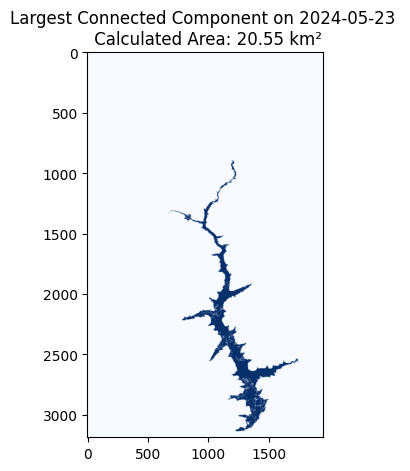

In [19]:
plt.figure(figsize=(5, 5))
plt.imshow(lcc_da.sel(time="2024-05-23").compute(), cmap='Blues')
plt.title(f'Largest Connected Component on 2024-05-23 \n Calculated Area: {area_da.sel(time="2024-05-23").compute():.2f} km²');

Compute and visualize the estimated areas over time

In [20]:
# Compute area time series (This can take a few minutes)
area_da = area_da.compute()

Plotting the entire time series

c:\Users\tsiokano\git\eopf-101\.venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


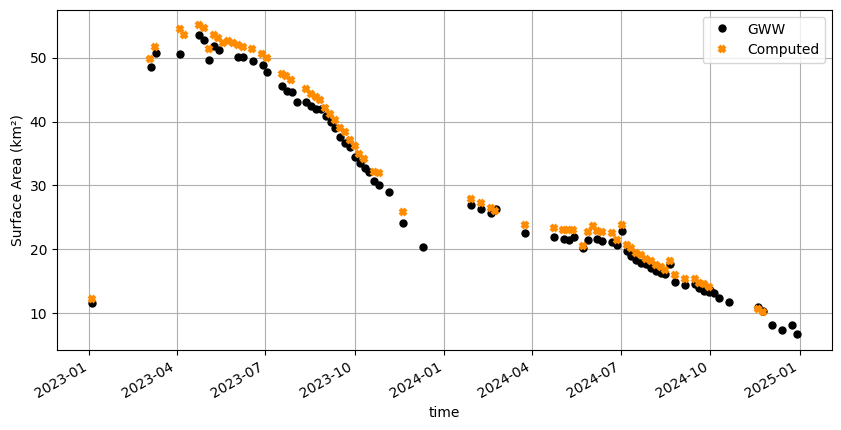

In [ ]:
plt.figure(figsize=(10, 5))

# --------
# I will delete the GWW part (see tasks below), I am plotting here just for our information
# --------
import os
gww_folder = R"p:\11210554-dtc-hydrology-next\Mita_Hills\reservoir_monitor_EO\gww_ts"
gww_area = pd.read_csv(os.path.join(gww_folder, "Surface Water Area.csv"), index_col=0, parse_dates=True)
gww_area.rename(columns={"Surface Water Area (km2)": "area"}, inplace=True)
gww_volume = pd.read_csv(os.path.join(gww_folder, "Surface Water Volume.csv"), index_col=0, parse_dates=True)
gww_volume.rename(columns={"Surface Water Volume (km3)": "volume"}, inplace=True)
df_gww = pd.merge(gww_area, gww_volume, left_index=True, right_index=True, how='inner')
df_gww["volume"] = df_gww["volume"] * 1e9
df_gww.index = pd.to_datetime(df_gww.index, format='ISO8601')
# ----------

plt.plot(df_gww.loc["2023":"2024", "area"].index, (df_gww.loc["2023":"2024", 'area']), ms=5, marker='o', linestyle=' ', color='k', label="GWW")
area_da.to_pandas().plot(
    marker='x', 
    ms=5,                
    markeredgewidth=3,     
    linestyle=' ', 
    color='darkorange', 
    label="Computed"
)

plt.ylabel('Surface Area (km²)')
plt.grid()
plt.legend();

<hr>

## Conclusion

In this notebook, we demonstrated how Sentinel-2 L1C data can be accessed and processed to monitor reservoir water surface area over a historical time series using Earth Observation techniques. To achieve this, we applied parts of the [Global Water Watch (GWW)](https://www.globalwaterwatch.earth/) algorithms (detailed description [here](https://www.nature.com/articles/s41598-022-17074-6)) to filter images, derive water masks, fill gaps and estimate reservoir surface.

The workflow relied on the `.zarr` data format from the [EOPF STAC Catalog](https://stac.browser.user.eopf.eodc.eu/?.language=en), which enables fast, efficient, and scalable data access directly from the cloud, using standard Python tools. Compared to the traditional `.safe` files/workflows, this approach reduces overhead, allowing us to produce reservoir time series in just a few minutes.

Overall, this demonstrates the strong potential of this catalog not only for retrospective reservoir monitoring but also for near-real-time operational applications.

<hr>

## 💪 Now it is your turn


Now that you’re familiar our reservoir detection workflow, based on the zarr format provided by the EOPF Sentinel STAC Catalog, it’s time to put your skills into practice! Below are suggested exercises that scale from replication to comparison and finally to an advanced extension using a different sensor.

**Overview of tasks:**
1. **Try another reservoir** – replicate the workflow for a different reservoir.  
2. **Compare with the official GWW algorithm** – analyze differences between our implementation and the GWW API results.  
3. **Explore SAR-based water extent estimation** – extend the workflow to Sentinel-1 SAR data and compare with optical results.

### Task 1: Try Another Reservoir

**Goal:** test how well the workflow generalizes to a different reservoir.

**Steps:**
1. Visit the [Global Water Watch (GWW) interactive viewer](https://www.globalwaterwatch.earth/map) and explore reservoirs.  
2. Pick a reservoir you find interesting and click **`DOWNLOAD.GEOJSON`** (bottom of the panel) to download its boundary polygon.  
3. Use **GeoPandas** to load the GeoJSON and compute the bounding box (`bbox`) for your new study area.  
4. Re-run this notebook’s processing pipeline using that bounding box.  

**Tips & ideas:**
- Choose reservoirs in different climates (e.g., semi-arid vs. humid tropical) to observe how clouds, vegetation and seasonal changes affect detection.
- Try several sizes: small vs. large reservoirs to see how morphological operations and the largest connected component step behave. Note that usually very large reservoirs are well measured using in-situ measurements and partial observations of surface area are less indicative of the state of the full reservoir.
 
You can use the following code snippet to get the WO dataset directly into a data array for your AOI 
```python
import ee
import geemap

ee.Authenticate()
ee.Initialize()

aoi = ee.Geometry.Rectangle([minx, miny, maxx, maxy])

# Load and process image
water_occurrence = (
    ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
    .select("occurrence")
    .unmask(0)
    .divide(100)
)

ds = geemap.ee_to_xarray(
    water_occurrence,
    geometry=aoi,
    scale=30,
    crs=crs_code,)

da = ds["occurrence"].isel(time=0).transpose("Y", "X").sortby("Y", ascending=False).drop_vars("time")
```

### Task 2: Compare with the official GWW algorithm  

**Goal:** explore differences between the current implementation and the official GWW outputs.

As described earlier in this notebook the GWW algorith is more complex combining many satelite sources and parts of the classification/filtering techiques/settigns are different, for example the largest connected components is not extracted. In addition the resulting surface water area time series in GWW are post-processed with
a temporal outlier filtering (quantile-based) to remove the remaining errors. Also one major difference is that in the raw algorith a long archive is exploited.

**Steps:**
1. Read the GWW API docs: `https://api.globalwaterwatch.earth/docs`.  
2. Install the API:  
   ```bash
   pip install gwwapi
3. Download timeseries for Mita Hills (reservoir id 88643) using the API (or the website)
4. Compare GWW's reported water area time series with your own estimates extracted from Sentinel-2 in this notebook.

You can use the following helper function to query the GWW API:

```python
import requests

def get_reservoir_ts_gww(reservoir_id, start_date, end_date):
    """
    Retrieve time series data for a given reservoir ID from the GWW API.
    start_date and end_date are strings in 'YYYY-MM-DD' format.
    """
    base_url = "https://api.globalwaterwatch.earth/v1"
    url = f"{base_url}/reservoir/{reservoir_id}/ts"

    params = {
        "start": f"{start_date}T00:00:00",
        "stop": f"{end_date}T23:59:59"
    }

    resp = requests.get(url, params=params)
    resp.raise_for_status()
    return resp.json()
```

### Task 3 (advanced): Explore water extent estimation with SAR Sentinel-1 Level-1 GRD

**Goal:**  
Adapt the detection workflow you developed for Sentinel-2 optical data to **Sentinel-1 SAR** data, and compare how it performs for the same reservoir.

**Reasoning:**

In this notebook, we used **Sentinel-2 L1C optical data** to detect reservoir water extent. The same logic - *Otsu thresholding*, *edge detection*, *morphological filtering*, and *largest connected component extraction* - can also be applied to **Sentinel-1 SAR** data. Since SAR measures **backscatter** instead of reflectance, we can’t compute indices like MNDWI or NDWI. Instead, we use the backscatter values directly to separate wet and dry pixels: water usually appears **dark (e.g. < −16 dB)**. SAR has the advantage of being **cloud-independent**, but can sometimes overestimate water, especially when **dry soil** also produces low backscatter. Also note that SAR requires preprocessing before using it like orbit correction, thermal noise removal, calibration, speckle filtering, terrain correction, conversion to dB etc.

**Steps:**

1. Download and preprocess Sentinel-1 GRD data (see the Flood Mapping - Time Series Analysis in Valencia example).  
2. Adjust the gww function to work with SAR, e.g. apply a simple mask (e.g. `backscatter < -16`), refine with **Otsu thresholding**, use existing morphological steps to clean the result and extract the reservoir (you can skip the water occurance filling).
3. Compare the SAR-based water area with your Sentinel-2 estimates.


<hr>

## What's next?

This online resource is under active development. So stay tuned for regular updates 🛰️.